# <center>Buy 'Til You Die: Customer Lifetime Value Prediction</center>

## Problem 

- A client should be regarded as having a higher churn risk if they used to make a purchase once every 20 days on average but have been inactive for 50 days. She might be about to choose a competitor's product line instead of our company. When our tool alerts the marketing team to consumers with high churn risks, they can consider discounts, promotions, and other outreach measures.
- We need a model that alerts us to clients who are at risk of leaving. Additionally, we want it to forecast how much each customer will spend. Additionally, it ought to determine the lifetime values of each of our clients while we're at it.


## Solution 

- These techniques are known as Buy 'Til You Die Models in data science. BTYD (Wikipedia): From a customer's "birth" (when she places her first purchase with our company) to the day of her "death" (when she chooses a rival and is hence dead to us, the firm she has spurned).


In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

from lifetimes.plotting import *
from lifetimes.utils import *
from lifetimes import *

In [2]:
data = pd.read_csv("OnlineRetail.csv", encoding="cp1252")
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## EDA

In [3]:
data.shape

(541909, 8)

In [4]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], format="%m/%d/%Y %H:%M").dt.date

- There are 135,080 missing values in the CustomerID column, and since our analysis is based on customers, 
- we will remove these missing values from the CustomerID column.

In [7]:
data = data[pd.notnull(data['CustomerID'])]

- Keeping records with non negative quantity

In [8]:
data = data[data['Quantity'] > 0]

- Add a new column depicting total sales

In [9]:
data['Total_Sales'] = data['Quantity'] * data['UnitPrice']

In [10]:
necessary_cols = ['CustomerID', 'InvoiceDate', 'Total_Sales']
data[necessary_cols]

,CustomerID,InvoiceDate,Total_Sales
0,17850.0,2010-12-01,15.30
1,17850.0,2010-12-01,20.34
2,17850.0,2010-12-01,22.00
3,17850.0,2010-12-01,20.34
4,17850.0,2010-12-01,20.34
...,...,...,...
541904,12680.0,2011-12-09,10.20
541905,12680.0,2011-12-09,12.60
541906,12680.0,2011-12-09,16.60
541907,12680.0,2011-12-09,16.60


In [11]:
print(f" Number of unique Customer:  {data['CustomerID'].nunique()}")

 Number of unique Customer:  4339


In [12]:
last_order_date = data['InvoiceDate'].max() #its checks the Last order date
print(f"last order date: {last_order_date}")

last order date: 2011-12-09


- based on lives.Plotting WW will import all the packages needed to plot or visualise the supplied data file, as well as the utility libraries that contain the supplied models for model prediction.


In [13]:
data = summary_data_from_transaction_data(data, 'CustomerID', 'InvoiceDate', monetary_value_col='Total_Sales', observation_period_end='2011-12-9')
data.reset_index().head()

,CustomerID,frequency,recency,T,monetary_value
0,12346.0,0.0,0.0,325.0,0.000000
1,12347.0,6.0,365.0,367.0,599.701667
2,12348.0,3.0,283.0,358.0,301.480000
3,12349.0,0.0,0.0,18.0,0.000000
4,12350.0,0.0,0.0,310.0,0.000000


- Built-in utility functions from lifetimes package to transform the transactional data (one row per purchase) into summary data (a frequency, recency, age and monetary).

- <b>frequency : </b> represents the number of repeat purchases the customer has made.
- <b>recency : </b> represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase.
- <b>T : </b> This is equal to the duration between a customer’s first purchase and the end of the period under study. This is equal to the duration between a customer’s first purchase and the end of the period under study.
- <b>monetary : </b> represents the average value of a given customer’s purchases.

In [14]:
one_time_buyers = round(sum(data['frequency'] == 0)/float(len(data))*(100),2)
print(f"Percentage of customers purchase the item only once: {one_time_buyers}%")

Percentage of customers purchase the item only once: 35.7%


## Frequency/Recency Analysis Using the BG/NBD Model

In [15]:
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 4339 subjects, a: 0.00, alpha: 68.89, b: 6.75, r: 0.83>


<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

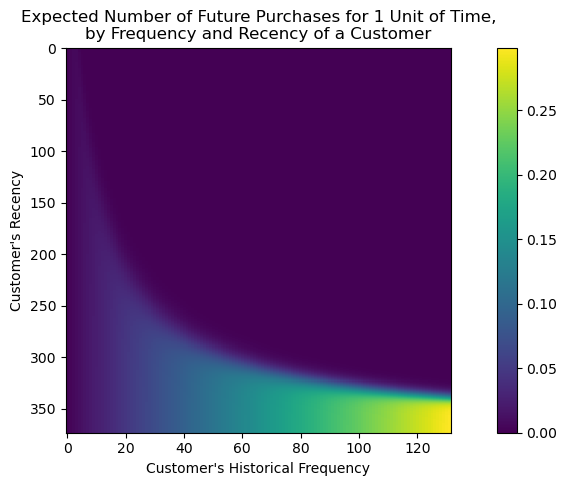

In [16]:
fig = plt.figure(figsize=(12,5))
plot_frequency_recency_matrix(bgf)

- We can see that if a customer has bought 120 times from you, and their latest purchase was when they were 330 weeks old (given the individual is 330 weeks old), then they are your best customer.

- Predict future transaction in next 10 days i.e.top 30 customers that the model expects them to make purchases 
- in the next 10 days, based on historical data

In [17]:
t = 10

data['pred_num_txn'] = round(bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T']),2)

data.sort_values(by='pred_num_txn', ascending=False).head(10).reset_index()

,CustomerID,frequency,recency,T,monetary_value,pred_num_txn
0,14911.0,131.0,372.0,373.0,1093.661679,2.98
1,12748.0,113.0,373.0,373.0,298.360885,2.58
2,17841.0,111.0,372.0,373.0,364.452162,2.53
3,15311.0,89.0,373.0,373.0,677.729438,2.03
4,14606.0,88.0,372.0,373.0,135.890114,2.01
5,12971.0,70.0,369.0,372.0,159.211286,1.61
6,13089.0,65.0,367.0,369.0,893.714308,1.50
7,14527.0,53.0,367.0,369.0,155.016415,1.23
8,13798.0,52.0,371.0,372.0,706.650962,1.20
9,16422.0,47.0,352.0,369.0,702.472340,1.09


<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

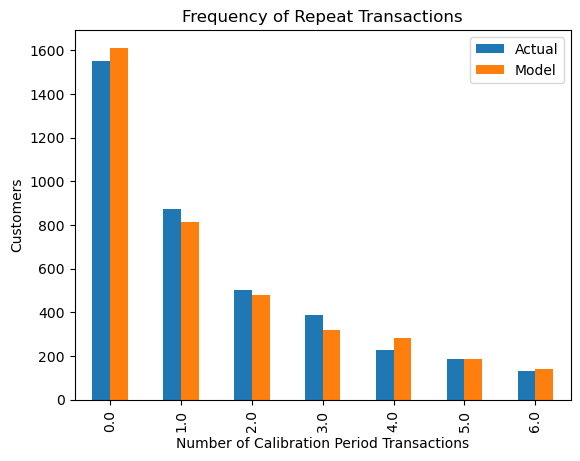

In [18]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

- Check if there is correlation between monetary value and frequency in order to use gamma gamma model for CLV calculation by pearson coeff.


In [19]:
data[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.046161
frequency,0.046161,1.000000


- Shortlist customers who had at least one repeat purchase with the company.

In [20]:
 shortlisted_customers = data[data['frequency']>0]
print(shortlisted_customers.head().reset_index())
print("-----------------------------------------")
print(f"The Number of Returning Customers are: {len(shortlisted_customers)}")

   CustomerID  frequency  recency      T  monetary_value  pred_num_txn
0     12347.0        6.0    365.0  367.0      599.701667          0.16
1     12348.0        3.0    283.0  358.0      301.480000          0.09
2     12352.0        6.0    260.0  296.0      368.256667          0.19
3     12356.0        2.0    303.0  325.0      269.905000          0.07
4     12358.0        1.0    149.0  150.0      683.200000          0.08
-----------------------------------------
The Number of Returning Customers are: 2790


- We didn't consider the economic impact of each transaction during this entire period; instead, we concentrated primarily on the occurrence of transactions. We can use the Gamma-Gamma submodel to estimate this. But first, we must extract summary information from transactional data that also includes the economic values of each transaction (such as revenues or profits).


In [21]:
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(shortlisted_customers['frequency'],
        shortlisted_customers['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 2.10, q: 3.45, v: 485.57>

In [22]:
#After applying Gamma-Gamma model, now we can estimate average transaction value for each customer. 
print(ggf.conditional_expected_average_profit(
        data['frequency'],
        data['monetary_value']
    ).head(10))

CustomerID
12346.0    416.917667
12347.0    569.988807
12348.0    333.762672
12349.0    416.917667
12350.0    416.917667
12352.0    376.166864
12353.0    416.917667
12354.0    416.917667
12355.0    416.917667
12356.0    324.008941
dtype: float64


In [23]:
data['pred_txn_value'] = round(ggf.conditional_expected_average_profit(
        data['frequency'],
        data['monetary_value']), 2)
data.reset_index()

,CustomerID,frequency,recency,T,monetary_value,pred_num_txn,pred_txn_value
0,12346.0,0.0,0.0,325.0,0.000000,0.02,416.92
1,12347.0,6.0,365.0,367.0,599.701667,0.16,569.99
2,12348.0,3.0,283.0,358.0,301.480000,0.09,333.76
3,12349.0,0.0,0.0,18.0,0.000000,0.10,416.92
4,12350.0,0.0,0.0,310.0,0.000000,0.02,416.92
...,...,...,...,...,...,...,...
4334,18280.0,0.0,0.0,277.0,0.000000,0.02,416.92
4335,18281.0,0.0,0.0,180.0,0.000000,0.03,416.92
4336,18282.0,1.0,119.0,126.0,77.840000,0.09,260.28
4337,18283.0,13.0,334.0,337.0,152.802308,0.34,174.52


- Here we calculate the CLV score for the top customers

In [24]:
data['CLV'] = round(ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    data['frequency'],
    data['recency'],
    data['T'],
    data['monetary_value'],
    time=12, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
), 2)

In [25]:
data.head()

,frequency,recency,T,monetary_value,pred_num_txn,pred_txn_value,CLV
CustomerID,,,,,,,
12346.0,0.0,0.0,325.0,0.000000,0.02,416.92,295.25
12347.0,6.0,365.0,367.0,599.701667,0.16,569.99,3010.93
12348.0,3.0,283.0,358.0,301.480000,0.09,333.76,1008.69
12349.0,0.0,0.0,18.0,0.000000,0.10,416.92,1337.11
12350.0,0.0,0.0,310.0,0.000000,0.02,416.92,306.93
